# Analyse the differences between BLASTp performance and that of the DNN models

In [1]:
# define the directory where the data is
data_path = "/home/jcapela/ec_numbers_prediction/required_data_ec_number_paper"

In [2]:
from plants_sm.data_structures.dataset.single_input_dataset import SingleInputDataset

test_dataset = SingleInputDataset.from_csv(f'{data_path}/data/test.csv',
                                            instances_ids_field="accession", representation_field="sequence",
                                            labels_field=slice(8, 2779))

/home/jcapela/miniconda3/envs/ec_number_prediction_2/lib/python3.10/site-packages/plants_sm/io/csv.py:56: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(self.path, **self.kwargs)


In [3]:
# read predictions from pickle file
import pickle

with open(f'{data_path}/predictions/predictions_esm2_3b.pkl', "rb") as f:
    predictions_esm2_3b = pickle.load(f)

In [4]:
from sklearn.metrics import f1_score, recall_score, precision_score

def get_metrics(dataset_y, predictions):
    f1_score_list = []
    recall_score_list = []
    precision_score_list = []
    for i in range(predictions.shape[1]):
        f1_score_i = f1_score(predictions[:, i], dataset_y[:, i])
        recall_score_i = recall_score(predictions[:, i], dataset_y[:, i])
        precision_score_i = precision_score(predictions[:, i], dataset_y[:, i])
        f1_score_list.append(f1_score_i)
        recall_score_list.append(recall_score_i)
        precision_score_list.append(precision_score_i)
    return f1_score_list, recall_score_list, precision_score_list

In [5]:
# write results to pickle
import pickle

f1_score_list, recall_score_list, precision_score_list = get_metrics(test_dataset.y, predictions_esm2_3b)

with open(f'{data_path}/f1_scores/esm2_t36_3B_UR50D_f1_score.pkl', 'wb') as f:
    pickle.dump(f1_score_list, f)

In [6]:
# now open everything
import pickle

with open(f'{data_path}/f1_scores/esm2_t36_3B_UR50D_f1_score.pkl', 'rb') as f:
    esm2_t36_3B_f1_score_list = pickle.load(f)

<AxesSubplot:title={'center':'F1 Score Distribution'}, ylabel='Count'>

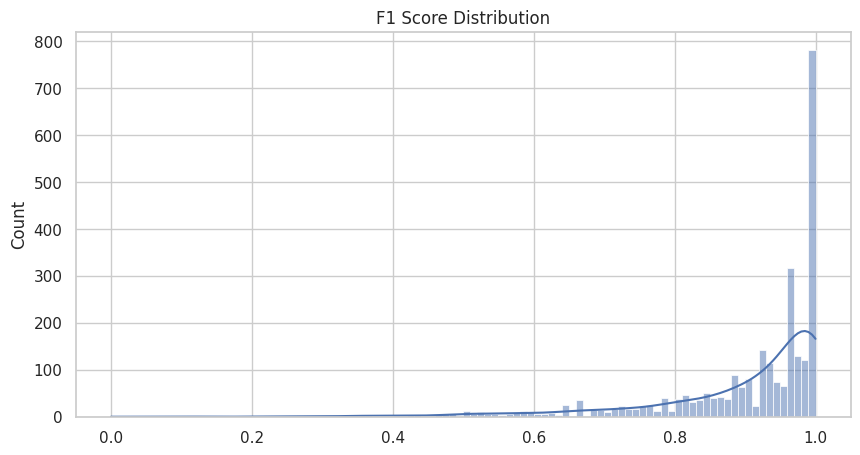

In [7]:
#write distribution of scores to graph
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
plt.title("F1 Score Distribution")
sns.histplot(f1_score_list, bins=100, kde=True)


# Get predictions for ProtBERT model

In [8]:
# read predictions from pickle file
import pickle

with open(f'{data_path}/predictions/predictions_prot_bert.pkl', "rb") as f:
    predictions_prot_bert = pickle.load(f)

In [16]:
# write results to pickle
import pickle

f1_score_list, recall_score_list, precision_score_list = get_metrics(test_dataset.y, predictions_prot_bert)

with open(f'{data_path}/f1_scores/prot_bert_f1_score.pkl', 'wb') as f:
    pickle.dump(f1_score_list, f)

In [9]:
# now open everything
import pickle

with open(f'{data_path}/f1_scores/prot_bert_f1_score.pkl', 'rb') as f:
    protein_bert_f1_score_list = pickle.load(f)

# Get predictions for ESM1b model

In [11]:
# read predictions from pickle file
import pickle

with open(f'{data_path}/predictions/predictions_esm1b.pkl', "rb") as f:
    predictions_esm1b = pickle.load(f)

In [23]:
# write results to pickle
import pickle

f1_score_list, recall_score_list, precision_score_list = get_metrics(test_dataset.y, predictions_esm1b)

with open(f'{data_path}/f1_scores/esm1b_f1_score.pkl', 'wb') as f:
    pickle.dump(f1_score_list, f)

In [10]:
# now open everything
import pickle

with open(f'{data_path}/f1_scores/esm1b_f1_score.pkl', 'rb') as f:
    esm1b_f1_score_list = pickle.load(f)

## Results for BLAST

In [12]:
import pandas as pd

blast_results = pd.read_csv(f'{data_path}/test_blast_predictions_right_format.csv')

/tmp/ipykernel_1173529/250125434.py:3: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  blast_results = pd.read_csv(f'{data_path}/test_blast_predictions_right_format.csv')


In [13]:
blast_results_true_values = pd.read_csv(f'{data_path}/test_right_format.csv')

/tmp/ipykernel_1173529/842780128.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  blast_results_true_values = pd.read_csv(f'{data_path}/test_right_format.csv')


In [10]:
predictions_blast = blast_results.iloc[:, 6:]
true_values = blast_results_true_values.iloc[:, 8:]
blast_results_copy = blast_results_true_values.copy()

In [11]:
import numpy as np
labels_names = np.array(test_dataset._labels_names)

In [12]:
del test_dataset

In [13]:
import numpy as np

# get the identifiers with predictions all set to zero
zero_predictions = []
for i in range(predictions_blast.shape[0]):
    if np.sum(predictions_blast.iloc[i, :]) == 0:
        zero_predictions.append(i)
len(zero_predictions)

638

In [16]:
non_homologues_dataset = blast_results_true_values.iloc[zero_predictions, 8:]

In [14]:
# drop columns with only zeros
def get_labels_to_remove(dataset, labels_names):
    labels_with_no_positive_sample = []
    for i, label in enumerate(labels_names):
        if dataset[label].sum() == 0:
            labels_with_no_positive_sample.append(i)
    return labels_with_no_positive_sample

In [17]:
labels_to_remove = get_labels_to_remove(non_homologues_dataset, labels_names)

In [ ]:
predictions_labels_removed = np.delete(predictions_blast, labels_to_remove, axis=1)

In [ ]:
y_pred = predictions_labels_removed[zero_predictions,:]
y_true = np.delete(np.array(non_homologues_dataset), labels_to_remove, axis=1)

In [22]:
import numpy as np

metrics = get_metrics(np.array(true_values), np.array(predictions_blast))

In [23]:
# write results to pickle
import pickle

with open(f'{data_path}/f1_scores/blast_f1_score.pkl', 'wb') as f:
    pickle.dump(metrics[0], f)

In [14]:
# now open everything
import pickle

with open(f'{data_path}/f1_scores/blast_f1_score.pkl', 'rb') as f:
    blast_f1_score = pickle.load(f)

In [15]:
blast_results = pd.read_csv(f'{data_path}/test_blast_predictions_right_format.csv')
blast_results_true_values = pd.read_csv(f'{data_path}/test_right_format.csv')

/tmp/ipykernel_1173529/3677728155.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  blast_results = pd.read_csv(f'{data_path}/test_blast_predictions_right_format.csv')
/tmp/ipykernel_1173529/3677728155.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  blast_results_true_values = pd.read_csv(f'{data_path}/test_right_format.csv')


# Compare the prediction of the main classes of EC numbers

In [2]:
# now open everything
import pickle

with open(f'{data_path}/f1_scores/blast_f1_score.pkl', 'rb') as f:
    blast_f1_score = pickle.load(f)

In [3]:
# now open everything
import pickle

with open(f'{data_path}/f1_scores/esm2_t36_3B_UR50D_f1_score.pkl', 'rb') as f:
    esm2_t36_3B_UR50D_f1_score_list = pickle.load(f)

In [4]:
# do this for protein bert
import pickle

with open(f'{data_path}/f1_scores/prot_bert_f1_score.pkl', 'rb') as f:
    protein_bert_f1_score_list = pickle.load(f) 

In [5]:
# now open everything
import pickle

with open(f'{data_path}/f1_scores/esm1b_f1_score.pkl', 'rb') as f:
    esm1b_f1_score_list = pickle.load(f)

In [6]:
import pandas as pd

train = pd.read_csv(f'{data_path}/data/train.csv')
validation = pd.read_csv(f'{data_path}/data/validation.csv')

# merge 
train_validation = pd.concat([train, validation])
del train
del validation

KeyboardInterrupt: 

In [26]:
import numpy as np
train_validation = train_validation.iloc[:, 8:]
num_labels = train_validation.shape[1]
samples_per_label = np.zeros(num_labels, dtype=int)

for label in range(num_labels):
    samples_per_label[label] = np.sum(train_validation.iloc[:, label])

In [27]:
# define the log 10 of the number of samples per label
log_samples_per_label = np.log10(samples_per_label)
log_samples_per_label

array([4.82922012, 4.98667322, 4.85340615, ..., 1.93449845, 1.80617997,
       1.93951925])

In [28]:
# write it to pickle
import pickle

with open(f'{data_path}/log_samples_per_label.pkl', 'wb') as f:
    pickle.dump(log_samples_per_label, f)

In [7]:
import pickle

with open(f'{data_path}/log_samples_per_label.pkl', 'rb') as f:
    log_samples_per_label = pickle.load(f)

In [31]:
del train_validation

In [8]:
import pandas as pd

labels = pd.read_csv(f'{data_path}/data/train.csv', nrows=2).columns[8:]

# Comparison between BLASTp and all the models

In [11]:
# compare the results of BLAST and ESM2 3B f1 scores

def get_comparison_results(model_f1_list, blast_f1_list):
    comparison = []
    for i in range(len(blast_f1_list)):
        comparison.append(model_f1_list[i] - blast_f1_list[i])
    return comparison

comparison_3b = get_comparison_results(esm2_t36_3B_UR50D_f1_score_list, blast_f1_score)
comparison_esm1b = get_comparison_results(esm1b_f1_score_list, blast_f1_score)
comparison_protein_bert = get_comparison_results(protein_bert_f1_score_list, blast_f1_score)

In [13]:
color_map = {'DNN ESM2 35M': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'DNN ESM2 150M': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'DNN ESM2 8M': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'DNN ProtBERT': (0.8352941176470589, 0.3686274509803922, 0.0),
 'DNN ESM2 3B': (0.8, 0.47058823529411764, 0.7372549019607844),
 'DNN ESM2 650M': (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 'DNN ESM1b': (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 'DeepEC CNN3': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 'DSPACE EC': (0.9254901960784314, 0.8823529411764706, 0.2),
 'Models + BLASTp ensemble': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'Models ensemble': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
    'BLASTp': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),}

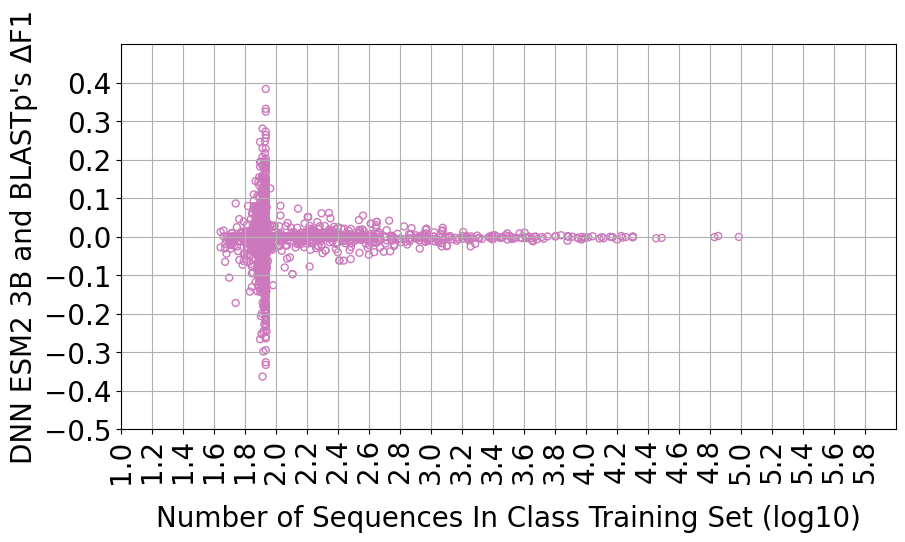

In [15]:
# Plotting the metric values as a function of the number of samples with value 1 per label

import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['savefig.transparent'] = True

def plot_metric_values(log_samples_per_label, metric_values, model_name):
    
    color = color_map[model_name]
    plt.figure(figsize=(10, 5))
    plt.scatter(log_samples_per_label, metric_values, color='blue', label='Metric Values', marker='o', facecolors='none', s=25, edgecolors=color)
    #plt.title(f'Comparison between {model_name} and BLASTp F1 Scores', pad=15, fontsize=23)
    plt.xlabel('Number of Sequences In Class Training Set (log10)', labelpad=15, fontsize=20)
    plt.ylabel(f"{model_name} and BLASTp's ΔF1", fontsize=20)
    plt.xlim(1, 6)
    plt.ylim(-0.5, 0.5)
    plt.grid(True)

    plt.yticks(np.arange(-0.5, 0.5, 0.1), fontsize=20)
    plt.xticks(np.arange(1, 6, 0.2), rotation=90, fontsize=20)
    plt.savefig(f'{model_name}_f1_comparison.png', dpi=400, bbox_inches='tight')

plot_metric_values(log_samples_per_label, comparison_3b, "DNN ESM2 3B")

In [22]:
labels_to_consider = []
for i, label in enumerate(log_samples_per_label):
    if label < 1.8:
        labels_to_consider.append(i)

values_to_evaluate = np.array(comparison_3b)[labels_to_consider]
negative_Values = len(values_to_evaluate[values_to_evaluate < 0])
positive_values = len(values_to_evaluate[values_to_evaluate > 0])
zero_values = len(values_to_evaluate[values_to_evaluate == 0])
print(negative_Values)
print(positive_values)
print(zero_values)

35
13
21


In [20]:
def get_best_above_threshold(metric_values, threshold):
    best_above_threshold = []
    for i, value in enumerate(metric_values):
        if threshold < 0 and value < threshold:
            best_above_threshold.append(i)
        elif threshold > 0 and value > threshold:
            best_above_threshold.append(i)
    return best_above_threshold

In [ ]:
import pandas as pd

test = pd.read_csv(f'{data_path}/data/test.csv')

In [ ]:
import numpy as np
test = test.iloc[:, 8:]
num_labels = test.shape[1]
samples_per_label_test = np.zeros(num_labels, dtype=int)

for label in range(num_labels):
    samples_per_label_test[label] = np.sum(test.iloc[:, label])

In [16]:
def get_results_for_threshold(comparison, samples_per_label_test, f1_score_list, method, blast=False):
    results = {}
    results["method"] = []
    results["threshold"] = []
    results["EC number"] = []
    results["Number of positives"] = []
    results["F1 score"] = []
    results["Difference of F1 score"] = []
    for threshold in [0.000000000000000000001, 0.1, 0.2, 0.3]:
        for i in get_best_above_threshold(comparison, threshold):
            results["method"].append(method)
            results["threshold"].append(threshold)
            results["EC number"].append(labels[i])
            results["Number of positives"].append(samples_per_label_test[i])
            results["F1 score"].append(np.array(f1_score_list)[i])
            results["Difference of F1 score"].append(comparison[i])
        
        if blast:
            for i in get_best_above_threshold(comparison, -threshold):
                results["method"].append(f"{method} - BLASTp")
                results["threshold"].append(threshold)
                results["EC number"].append(labels[i])
                results["Number of positives"].append(samples_per_label_test[i])
                results["F1 score"].append(np.array(blast_f1_score)[i])
                results["Difference of F1 score"].append(comparison[i])

    return results

In [17]:
import pandas as pd

results = pd.DataFrame(get_results_for_threshold(comparison_3b, samples_per_label_test, esm2_t36_3B_UR50D_f1_score_list, "DNN ESM2 3B"))

NameError: name 'samples_per_label_test' is not defined

In [28]:
results = pd.concat((results, pd.DataFrame(get_results_for_threshold(comparison_esm1b, samples_per_label_test, esm1b_f1_score_list, "DNN ESM1b"), 
            )))

In [29]:
results = pd.concat((results, pd.DataFrame(get_results_for_threshold(comparison_protein_bert, samples_per_label_test, protein_bert_f1_score_list, "DNN ProtBERT"))))

In [ ]:
results.to_csv("results_for_threshold_by_ec_by_method.csv", index=False)

In [30]:
import pandas as pd

results = pd.DataFrame(get_results_for_threshold(comparison_3b, samples_per_label_test, esm2_t36_3B_UR50D_f1_score_list, "DNN ESM2 3B", blast=True))
results = pd.concat((results, pd.DataFrame(get_results_for_threshold(comparison_esm1b, samples_per_label_test, esm1b_f1_score_list, "DNN ESM1b", blast=True), 
            )))
results = pd.concat((results, pd.DataFrame(get_results_for_threshold(comparison_protein_bert, samples_per_label_test, protein_bert_f1_score_list, "DNN ProtBERT", blast=True))))
results.to_csv("results_for_threshold_by_ec_by_method_with_blast.csv", index=False)

In [113]:
thresholds = [0.0000000000000000000001,0.1, 0.2, 0.3, 0.4]
results_comparison = {}
results_comparison["threshold"] = []
results_comparison["method"] = []
results_comparison["value"] = []



for threshold in thresholds:
    if threshold == 0.0000000000000000000001:
        results_comparison["threshold"].append(0)
        results_comparison["threshold"].append(0)
    else:
        results_comparison["threshold"].append(threshold)
        results_comparison["threshold"].append(threshold)
    results_comparison["method"].append("DNN ESM2 3B")
    results_comparison["value"].append(len(get_best_above_threshold(comparison_3b, threshold)))

    
    results_comparison["method"].append("BLASTp")
    results_comparison["value"].append(len(get_best_above_threshold(comparison_3b, -threshold)))

In [114]:
comparison_bar_plot = pd.DataFrame(results_comparison)
comparison_bar_plot

,threshold,method,value
0,0.0,DNN ESM2 3B,792
1,0.0,BLASTp,1093
2,0.1,DNN ESM2 3B,107
3,0.1,BLASTp,131
4,0.2,DNN ESM2 3B,14
5,0.2,BLASTp,23
6,0.3,DNN ESM2 3B,3
7,0.3,BLASTp,3
8,0.4,DNN ESM2 3B,0
9,0.4,BLASTp,0


In [111]:
def generate_bar_plot(comparison_bar_plot, color_palette):
    # Create two subplots
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [1, 2], 'hspace': 0.1})

    # Plot on the first subplot (lower values)
    sns.barplot(x='threshold', y='value', hue='method', data=comparison_bar_plot, ax=ax1, palette=color_palette)
    
    ax1.set_ylim(700, 1400)  # Adjust for the lower range of values
    ax1.legend().remove()
    ax1.set_xlabel('')
    ax1.set_ylabel('', fontsize=20)

    ax1.tick_params(labelsize=20)
    

    # Plot on the second subplot (higher values)
    sns.barplot(x='threshold', y='value', hue='method', data=comparison_bar_plot, ax=ax2, palette=color_palette)
    ax2.set_ylim(0, 200)  # Adjust for the higher range of values
    ax2.legend(title='Method', fontsize=20, title_fontsize=20)
    ax2.set_xlabel('Threshold', fontsize=20)
    ax2.set_ylabel('Number of ΔF1 > threshold', fontsize=20)
    ax2.tick_params(labelsize=20)

    # Function to add text annotations correctly
    def add_bar_value_annotations(ax):
        ylim = ax.get_ylim()
        y_range = ylim[1] - ylim[0]
        for p in ax.patches:
            height = p.get_height()
            if height < ylim[1]:
                ax.text(p.get_x() + p.get_width() / 2., 
                        height + (y_range * 0.01),  # Slightly above the bar
                        f'{height:.0f}', 
                        ha='center', va='bottom', fontsize=20)

    # Adding values on top of the bars
    add_bar_value_annotations(ax2)
    add_bar_value_annotations(ax1)


    # Adding diagonal lines to indicate the break in the y-axis
    d = 0.015  # size of the diagonal lines
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

    # Hide spines between ax1 and ax2
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    #plt.suptitle('Number of Classes with F1 Score Difference Above Threshold', y=0.95, fontsize=25)

In [115]:
color_map = {'DNN ESM2 35M': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'DNN ESM2 150M': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'DNN ESM2 8M': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'DNN ProtBERT': (0.8352941176470589, 0.3686274509803922, 0.0),
 'DNN ESM2 3B': (0.8, 0.47058823529411764, 0.7372549019607844),
 'DNN ESM2 650M': (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 'DNN ESM1b': (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 'DeepEC CNN3': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 'DSPACE EC': (0.9254901960784314, 0.8823529411764706, 0.2),
 'Models + BLASTp ensemble': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'Models ensemble': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
    'BLASTp': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),}

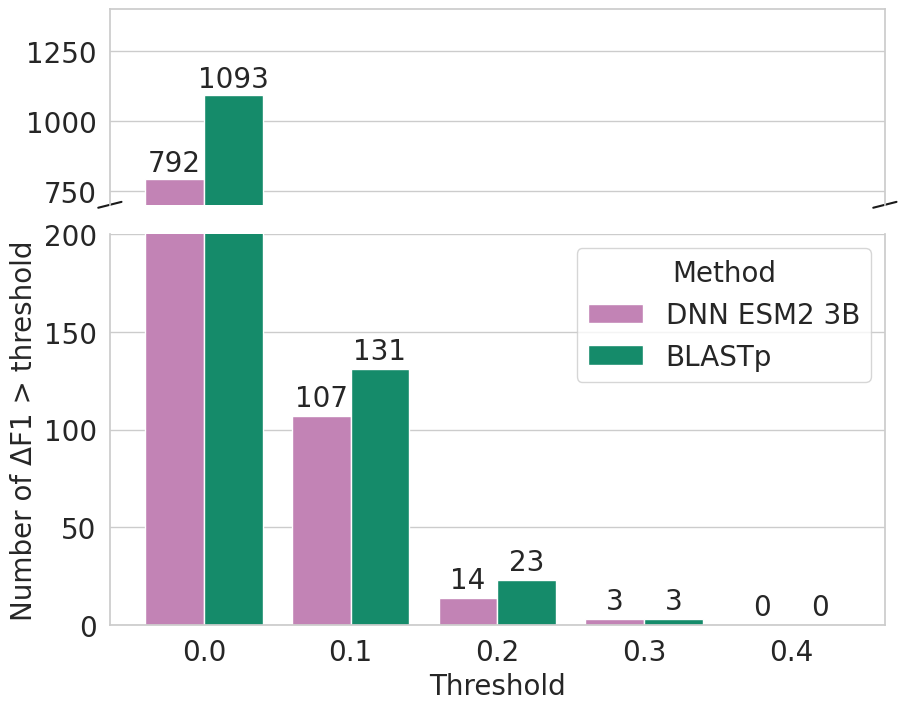

In [116]:
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Base color
base_color = (0.8, 0.47058823529411764, 0.7372549019607844)


# Create variations of the base color
# color_palette = [base_color]
# for i in range(1, 3):
#     varied_color = tuple([max(min(c * (1.0 + i * 0.8), 1), 0) for c in base_color])
#     color_palette.append(varied_color)

generate_bar_plot(comparison_bar_plot, color_map)
#plt.savefig("esm2_3b_above_threshold.png", dpi=400, bbox_inches='tight')


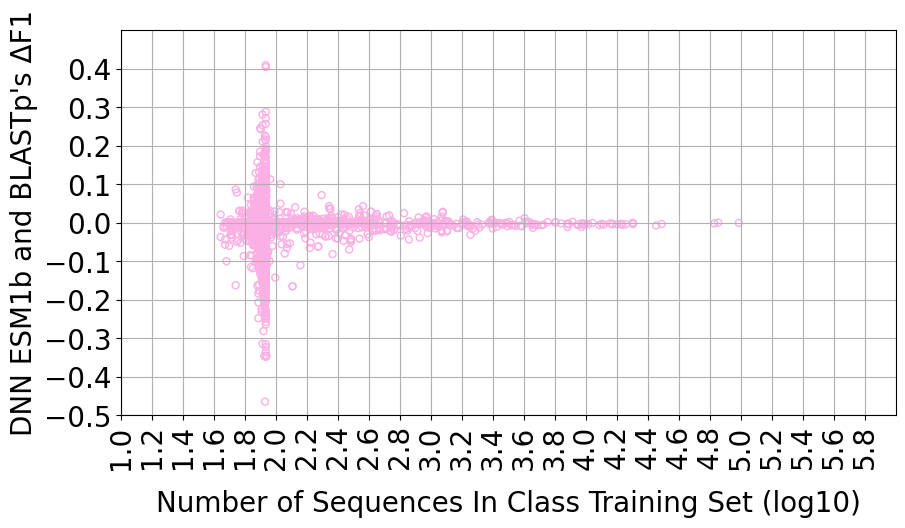

In [19]:
plot_metric_values(log_samples_per_label, comparison_esm1b, "DNN ESM1b")

In [99]:
labels_to_consider = []
for i, label in enumerate(log_samples_per_label):
    if label < 1.8:
        labels_to_consider.append(i)

values_to_evaluate = np.array(comparison_esm1b)[labels_to_consider]
negative_Values = len(values_to_evaluate[values_to_evaluate < 0])
positive_values = len(values_to_evaluate[values_to_evaluate > 0])
zero_values = len(values_to_evaluate[values_to_evaluate == 0])
print(negative_Values)
print(positive_values)
print(zero_values)

37
10
22


In [117]:
thresholds = [0.0000000000000000000001,0.1, 0.2, 0.3, 0.4]
results_comparison = {}
results_comparison["threshold"] = []
results_comparison["method"] = []
results_comparison["value"] = []



for threshold in thresholds:
    if threshold == 0.0000000000000000000001:
        results_comparison["threshold"].append(0)
        results_comparison["threshold"].append(0)
    else:
        results_comparison["threshold"].append(threshold)
        results_comparison["threshold"].append(threshold)
    results_comparison["method"].append("DNN ESM1b")
    results_comparison["value"].append(len(get_best_above_threshold(comparison_esm1b, threshold)))

    results_comparison["method"].append("BLASTp")
    results_comparison["value"].append(len(get_best_above_threshold(comparison_esm1b, -threshold)))

comparison_bar_plot = pd.DataFrame(results_comparison)

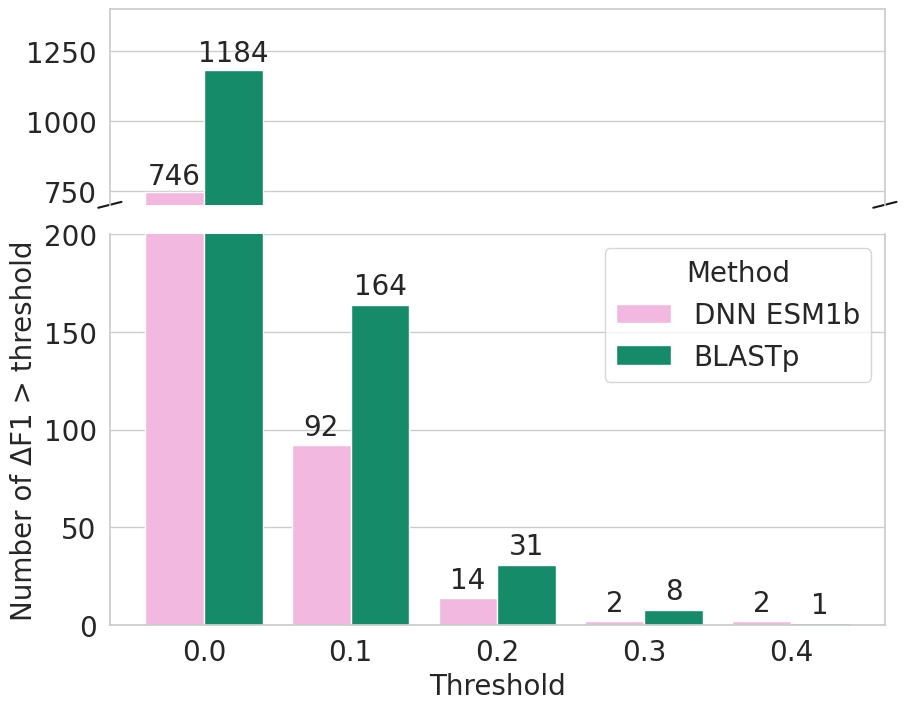

In [118]:
# Set Seaborn style
sns.set(style="whitegrid")

# Base color
base_color = color_map["DNN ESM1b"]

# Create variations of the base color
color_palette = [base_color]
for i in range(1, 3):
    varied_color = tuple([max(min(c * (1.0 + i), 1), 0) for c in base_color])
    color_palette.append(varied_color)

generate_bar_plot(comparison_bar_plot, color_map)


In [82]:
print(len(get_best_above_threshold(comparison_esm1b, 0.1)))
print(len(get_best_above_threshold(comparison_esm1b, -0.1)))

92
164


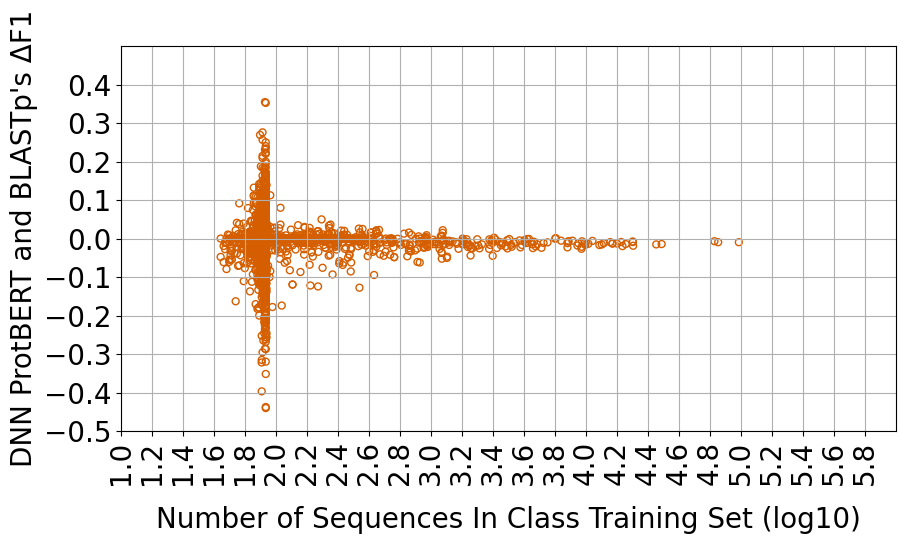

In [20]:
plot_metric_values(log_samples_per_label, comparison_protein_bert, "DNN ProtBERT")

In [103]:
labels_to_consider = []
for i, label in enumerate(log_samples_per_label):
    if label < 1.8:
        labels_to_consider.append(i)

values_to_evaluate = np.array(comparison_protein_bert)[labels_to_consider]
negative_Values = len(values_to_evaluate[values_to_evaluate < 0])
positive_values = len(values_to_evaluate[values_to_evaluate > 0])
zero_values = len(values_to_evaluate[values_to_evaluate == 0])
print(negative_Values)
print(positive_values)
print(zero_values)

39
14
16


In [119]:
thresholds = [0.0000000000000000000001,0.1, 0.2, 0.3, 0.4]
results_comparison = {}
results_comparison["threshold"] = []
results_comparison["method"] = []
results_comparison["value"] = []



for threshold in thresholds:
    if threshold == 0.0000000000000000000001:
        results_comparison["threshold"].append(0)
        results_comparison["threshold"].append(0)
    else:
        results_comparison["threshold"].append(threshold)
        results_comparison["threshold"].append(threshold)
    results_comparison["method"].append("DNN ProtBERT")
    results_comparison["value"].append(len(get_best_above_threshold(comparison_protein_bert, threshold)))

    results_comparison["method"].append("BLASTp")
    results_comparison["value"].append(len(get_best_above_threshold(comparison_protein_bert, -threshold)))

comparison_bar_plot = pd.DataFrame(results_comparison)

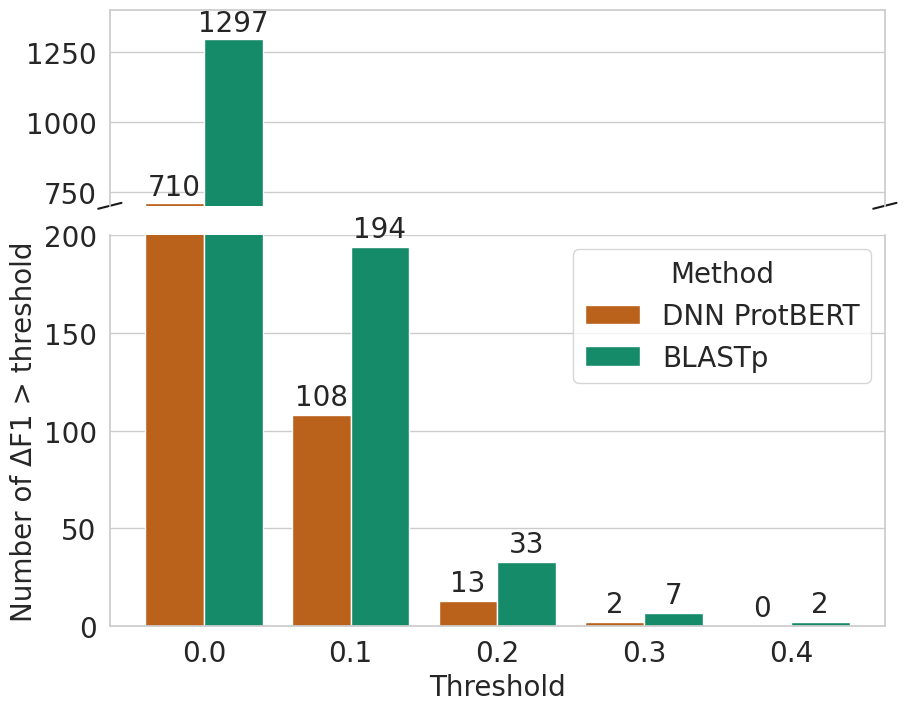

In [120]:
# Set Seaborn style
sns.set(style="whitegrid")

# Base color
base_color = color_map["DNN ProtBERT"]

# Create variations of the base color
color_palette = [base_color]
for i in range(1, 3):
    varied_color = tuple([max(min(c * (1.0 + i * 0.8), 1), 0) for c in base_color])
    color_palette.append(varied_color)

generate_bar_plot(comparison_bar_plot, color_map)


In [39]:
import numpy as np
import matplotlib.pyplot as plt

blast_values_level_1 = blast_f1_score[:7]
esm2_3b_values_level_1 = f1_score_list[:7]

import matplotlib.pyplot as plt

def generate_comparison_graph(blast_values, esm2_3b_values, protein_bert, esm1b, title, labels):
    # Sample data for the first 7 metrics of BLAST and esm2 3B models
    metrics = labels

    # Set the y-axis limits from 0.9 to 1
    plt.ylim(0.96, 1)

    bars = []
    # Create bar plots for BLAST and esm2 3B metrics with different colors
    bar4 = plt.bar(metrics, esm1b, label='ESM1b DNN', alpha=0.7, color='red')
    bar1 = plt.bar(metrics, blast_values, label='BLAST', alpha=0.7, color='lightcoral')
    bar2 = plt.bar(metrics, esm2_3b_values, label='ESM2 3B DNN', alpha=0.7, color='forestgreen')
    bar3 = plt.bar(metrics, protein_bert, label='ProteinBERT DNN', alpha=0.7, color='blue')
   

    # Add values on top of the bars with different colors and heights
    for i, (bar1_value, bar2_value, bar3_value, bar4_value) in enumerate(zip(blast_values, esm2_3b_values, protein_bert, esm1b)):
        plt.text(i, max(bar1_value, bar2_value, bar3_value ,bar4_value) + 0.007, f'{bar4_value:.3f}', ha='center', color='red', fontsize=10, fontweight='bold')
        plt.text(i, max(bar1_value, bar2_value, bar3_value, bar4_value) + 0.005, f'{bar3_value:.3f}', ha='center', color='blue', fontsize=10, fontweight='bold')
        plt.text(i, max(bar1_value, bar2_value, bar3_value, bar4_value) + 0.003, f'{bar1_value:.3f}', ha='center', color='lightcoral', fontsize=10, fontweight='bold')
        plt.text(i, max(bar1_value, bar2_value, bar3_value, bar4_value) + 0.001, f'{bar2_value:.3f}', ha='center', color='forestgreen', fontsize=10, fontweight='bold')



    # Set labels and title
    plt.xlabel('EC')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

    # Show the plot
    plt.tight_layout()
    plt.show()


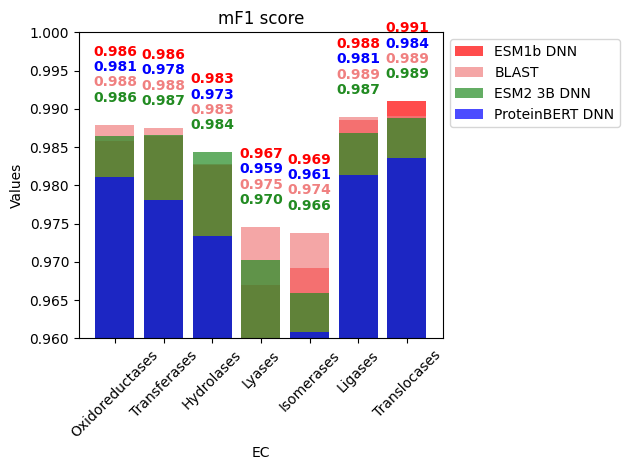

In [28]:
labels_names_level1 = ["Oxidoreductases", "Transferases", "Hydrolases", "Lyases", "Isomerases", "Ligases", "Translocases"]

blast_values_level_1 = blast_f1_score[:7]
esm2_3b_values_level_1 = esm2_t36_3B_UR50D_f1_score_list[:7]
protein_bert_values_level_1 = protein_bert_f1_score_list[:7]
esm1b_values_level_1 = esm1b_f1_score_list[:7]

generate_comparison_graph(blast_values_level_1, esm2_3b_values_level_1, protein_bert_values_level_1, esm1b_values_level_1, "mF1 score", labels_names_level1)

In [32]:
import pandas as pd

#blast_results_true_values = pd.read_csv("test_right_format.csv")
labels_names = np.array(test_dataset._labels_names)
#del blast_results_true_values
# Find strings that match the pattern

In [33]:
import re
# Regular expression pattern to match \d.\d+
pattern = r"^\d+.\d+$"

matched_strings = [string for i, string in enumerate(labels_names) if re.match(pattern, string)]
matched_indexes = [i for i, string in enumerate(labels_names) if re.match(pattern, string)]

In [34]:
blast_values = np.array(blast_f1_score)[matched_indexes]
esm2_3b_values = np.array(esm2_t36_3B_UR50D_f1_score_list)[matched_indexes]
protein_bert_values = np.array(protein_bert_f1_score_list)[matched_indexes]
esm1b_values = np.array(esm1b_f1_score_list)[matched_indexes]

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_heatmap(metric, model_values, matched_strings, model_names):
    plt.figure(figsize=(40, 8))
    heat_map = sns.heatmap(model_values, annot=True, xticklabels=matched_strings, yticklabels=model_names)
    plt.xlabel('EC', fontsize=14)
    plt.ylabel(f'{metric} Score', fontsize=14)
    plt.title(f'{metric} Score Heatmap for EC numbers in the level 2', fontsize=14)
    heat_map.tick_params(axis='y', labelsize=14)
    plt.show()


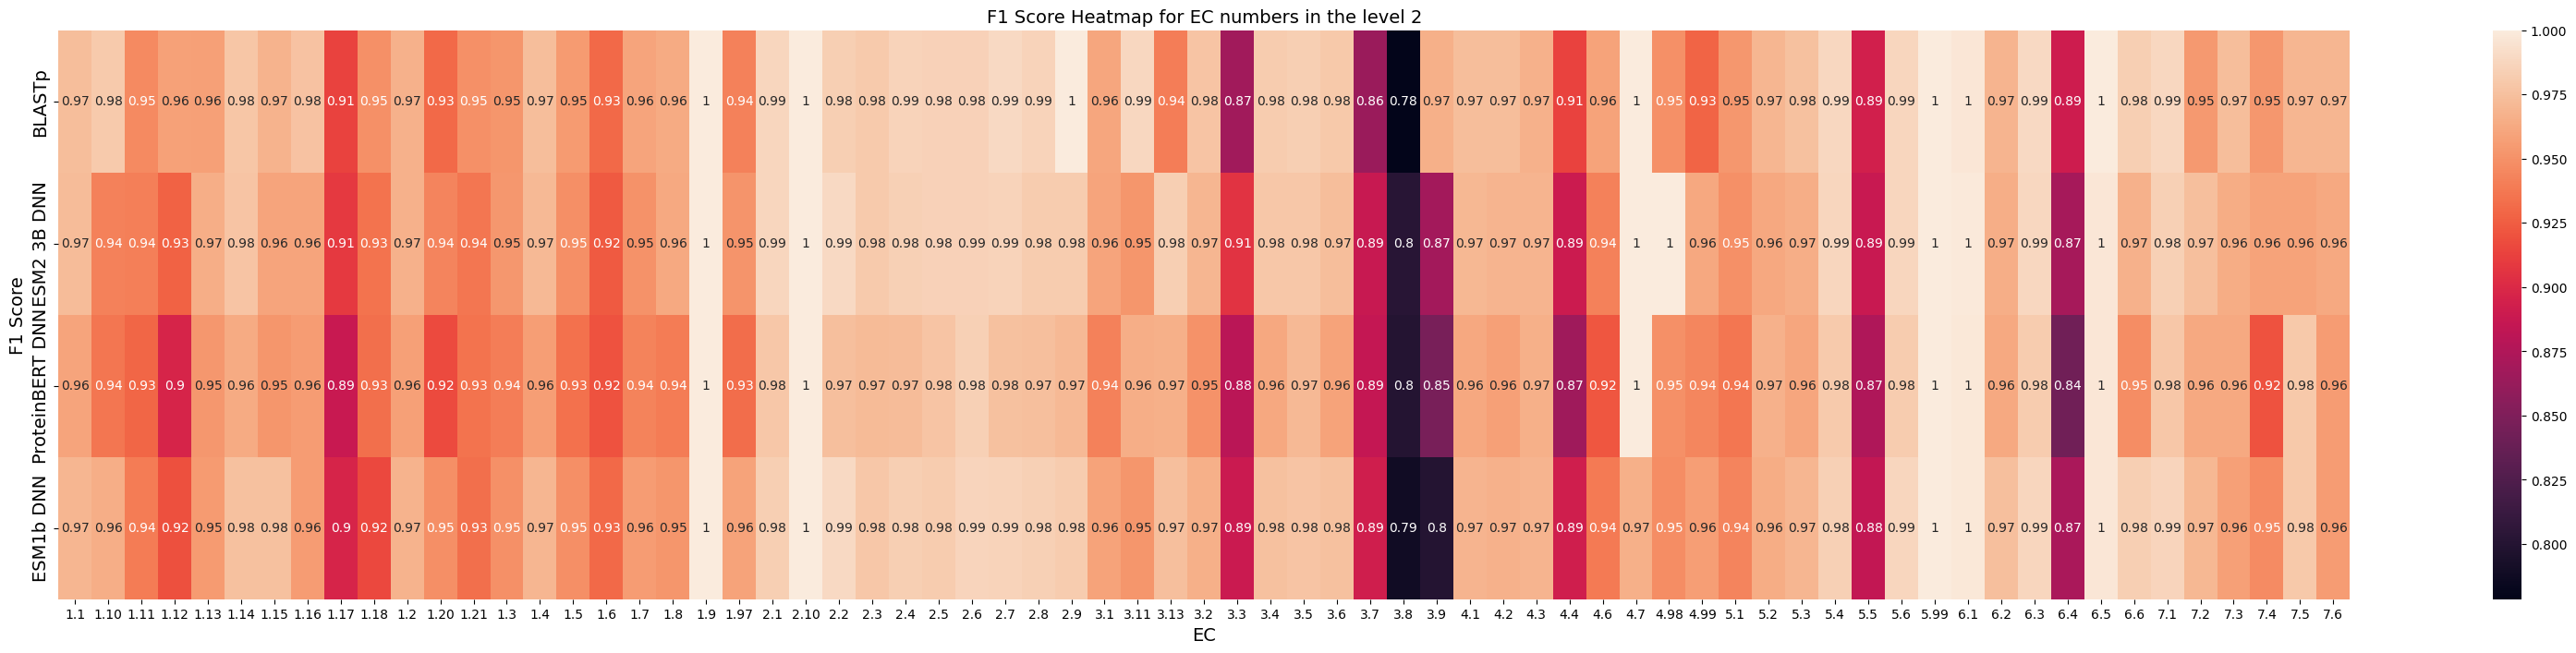

In [68]:
# create a heatmap with the values of f1 score for the list of matched strings


blast_values = np.array(blast_f1_score)[matched_indexes]
esm2_3b_values = np.array(esm2_t36_3B_UR50D_f1_score_list)[matched_indexes]
protein_bert_values = np.array(protein_bert_f1_score_list)[matched_indexes]
esm1b_values = np.array(esm1b_f1_score_list)[matched_indexes]

create_heatmap("F1", [blast_values, esm2_3b_values, protein_bert_values, esm1b_values], matched_strings, ["BLASTp", "ESM2 3B DNN", "ProteinBERT DNN", "ESM1b DNN"])